# 4.1 Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import re
import string

from sklearn.model_selection import train_test_split

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
newstopwords = ['rt', 'https', 'http', 'co',  'amp', 'vaccine', 'covid','vaccinate', 'vaccination', 'people', 'coronavirus','want', 'still', 'know', 'make', 'vaccinated', 'vaccines', 'u', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
stop_words.extend(newstopwords)

In [2]:
df = pd.read_csv('../Dataset/cleaned_dataset.csv', encoding = "utf-8")
df.drop("Unnamed: 0",axis=1,inplace=True)

In [3]:
df.head()

,text,is_misinfo
0,My 87 year old grandmother has been quarantini...,0
1,I’m so excited that with this vaccine I can se...,0
2,So excited that I was able to close out 2020 o...,0
3,"Well, it happened. My daughter used my grandch...",1
4,"I’m getting my COVID-19 vaccine, baby! I’m so ...",0


In [4]:
def remove_hashtag(text):
    sep = '#'
    return text.split(sep, 1)[0]

In [5]:
df['text'] = df['text'].apply(lambda x: remove_hashtag(x))
df.head()

,text,is_misinfo
0,My 87 year old grandmother has been quarantini...,0
1,I’m so excited that with this vaccine I can se...,0
2,So excited that I was able to close out 2020 o...,0
3,"Well, it happened. My daughter used my grandch...",1
4,"I’m getting my COVID-19 vaccine, baby! I’m so ...",0


In [6]:
import spacy
nlp = spacy.load('en_core_web_sm')

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = ''.join([c for c in text if c not in string.punctuation])
    tokens = re.split('\W+', text)
    text = ' '.join([word for word in tokens if word not in stop_words])
    text = nlp(text)
    text = ' '.join([word.lemma_ for word in text])
    return text

In [7]:
df['text'] = df['text'].apply(lambda x: clean_text(x))
df.head()

,text,is_misinfo
0,year old grandmother quarantine florida house ...,0
1,excited see day get back work thank celebrate ...,0
2,excited able close positive note get first dose,0
3,well happen daughter use grandchild try guilt ...,1
4,get baby fuck excited,0


# 4.2 Splitting Data

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], 
                                                    df['is_misinfo'], 
                                                    test_size=.2, 
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10301,), (2576,), (10301,), (2576,))

In [9]:
X_train.str.split()

7535                                                [dose]
7963     [alert, bioweapon, doctor, testify, healthcare...
5412     [literally, drive, anywhere, idc, anymore, mis...
188                             [widespread, availability]
1123     [hate, daniel, diaz, worry, what, s, there, s,...
                               ...                        
11964    [happy, grantparent, year, old, receive, first...
5191                                   [got, first, shoot]
5390                                                    []
860             [schedule, receive, first, dose, tomorrow]
7270                          [guess, get, moderna, shoot]
Name: text, Length: 10301, dtype: object

# 4.3 Tokenization

In [10]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000, oov_token=True)
tokenizer.fit_on_texts(X_train)

In [11]:
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

In [12]:
len(tokenizer.word_index)
# Shouldn't length = 5000??????

12992

# 4.4 Padding

In [13]:
max_len_train=0
for i in X_train_tokens:
    if len(i) > max_len_train:
        max_len_train = len(i)
print(f'Max length of training: {max_len_train}')

Max length of training: 34


In [14]:
from keras.preprocessing.sequence import pad_sequences

X_train_pad = pad_sequences(X_train_tokens, padding='pre', maxlen=max_len_train)
X_test_pad = pad_sequences(X_test_tokens, padding='pre', maxlen=max_len_train)

# 4.5 GloVE Embedding

- chck out fasttext embedding***

In [20]:
# !wget -q https://huggingface.co/stanfordnlp/glove/resolve/main/glove.twitter.27B.zip

In [21]:
# ! unzip glove.twitter.27B.zip

In [23]:
glove_dict = {}
with open('../Dataset/3123e7f5c3f6a30095d413b12fc3284bbf717acd2a9bed63d1c7c13bf5223352/glove.twitter.27B.100d.txt', 'r') as file:
    for line in file:
        val = line.split()
        word = val[0]
        glove_vec = val[1:]
        glove_dict[word] = np.array(glove_vec).astype(np.float64)
file.close()

In [24]:
vocab_size = len(tokenizer.word_index) + 1
glove_matrix = np.zeros((vocab_size, 100))  # change shape based on which glove file was used (25, 50, 100, 200)

for word, index in tokenizer.word_index.items():
    if index < vocab_size:
        vec = glove_dict.get(word)
        if vec is not None:
            glove_matrix[index] = vec

In [25]:
glove_matrix.shape

(12993, 100)

In [26]:
glove_matrix

array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [-0.11164  ,  0.35396  , -0.21636  , ..., -0.10389  ,  0.39103  ,
         0.0045548],
       ...,
       [-0.086452 , -0.15659  ,  0.038341 , ...,  0.11365  , -0.14378  ,
         1.1634   ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ]])

# 4.6 Words Missing from GloVe Model

In [27]:
np.where(~glove_matrix.any(axis=1))[0].shape

(3613,)

In [28]:
glove_matrix.shape

(12993, 100)

In [29]:
np.where(~glove_matrix.any(axis=1))[0].shape[0]/glove_matrix.shape[0]

0.27807280843531135

In [30]:
for word, index in tokenizer.word_index.items():
    if glove_dict.get(word) is None:
        print(word)

True
bioweapon
bitchute
fauci
jampj
sterility
vaxxed
unteste
pfizerbiontech
vaer
tenpenny
socalle
sinovac
sinopharm
liabilityfree
hotze
forceinjecte
fasttracke
vaccineit
sideeffect
oxfordastrazeneca
massivescale
biontech
lifesite
ivermectin
vaccinethe
hydroxychloroquine
flupneumonia
hcq
formerpfizer
postvaccine
antivaxxer
borisjohnson
antivaccine
vaccinei
racespecific
selfreplicating
provincially
twoyearold
grtvnews
modernatx
nanoparticle
genetherapy
yethmmif
confusedthat
therapydid
experimentalyepso
shotyoull
jkjavmy
plandemic
darpafunde
cdcgov
vaccinehesitancy
fordnation
vaxx
antivax
covaxin
nprcs
antivaxx
preplanne
vaccinator
joebiden
depopulate
yayyy
eugenic
preexist
inoculation
incarcerationcall
vaccinesall
phonybecause
naturehow
vaccinenever
afld
youtubemusic
antibodie
novavax
vaccinegene
unapprove
pathogenic
epochtime
vaxhunterscan
selfreplicate
vaccineso
kamalaharris
todayi
adjuvant
knowread
falsepositive
covishield
immunocompromise
vaccinewhat
nhsuk
cowin
mnra
genealtere
ottaw

livehave
warsthey
virusthen
handsonphx
coooo
nygovcuomo
ashleybakowski
itgreatgameindia
vaccineseriously
safethis
vaccinewill
pantsula
voshoall
recombinant
adenovirusvector
astraveneca
paperthe
ampget
spreaderso
tricounty
impend
palsey
anafilaxis
publicthank
yayshamsaldeen
sheinfashion
novawish
vaccinehindus
nonhindus
thewirein
swarajyamag
healthgovau
affectsif
toothbrushe
robertkennedyjr
brianlilley
adminfirst
phyzer
dostributeor
alliesbe
doseim
heartbreake
sinovacabah
ucrhealth
roysambu
vaccineceo
saysit
dangerousdont
disgustingdoe
ottawahospital
vaccinedelaye
faceapp
bioweaponthey
pleaseall
youngerdo
miocarditisan
spermthis
swathe
neoantigen
cleanziop
mannnnnnn
seriesbeginning
pennsylvanian
easyif
coviddont
lifefor
skynew
communitie
thomasmcelveen
inflameinflammation
artrixart
adamdkent
checkeri
plangreat
feverleft
nongmo
humanye
alongvaccine
latimeshealth
latime
nickcucc
controlthis
uwmedicine
activatedyet
suntime
patientselderly
obligatorydo
thisthe
safedo
wlmrt
clevelandclinic
pr

# 4.7 Model Building

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [32]:
model=Sequential()
model.add(Embedding(vocab_size, 100, weights=[glove_matrix], input_length=max_len_train, trainable=False))
model.add(Dropout(.1))
model.add(LSTM(150))
model.add(Dropout(.1))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 100)           1299300   
                                                                 
 dropout (Dropout)           (None, 34, 100)           0         
                                                                 
 lstm (LSTM)                 (None, 150)               150600    
                                                                 
 dropout_1 (Dropout)         (None, 150)               0         
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 1,450,051
Trainable params: 150,751
Non-trainable params: 1,299,300
_________________________________________________________________
None


# 4.8 Training Model

In [33]:
from tensorflow.keras.callbacks import EarlyStopping
ES = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   patience=5,
                   restore_best_weights=True)
history = model.fit(X_train_pad, 
                    y_train, 
                    validation_split=.15, 
                    epochs=15, 
                    batch_size=8, 
                    callbacks=ES)

Epoch 1/15
1095/1095 [==============================] - 19s 15ms/step - loss: 0.2437 - accuracy: 0.9061 - val_loss: 0.1979 - val_accuracy: 0.9172
Epoch 2/15
1095/1095 [==============================] - 18s 17ms/step - loss: 0.1806 - accuracy: 0.9256 - val_loss: 0.1737 - val_accuracy: 0.9327
Epoch 3/15
1095/1095 [==============================] - 18s 16ms/step - loss: 0.1464 - accuracy: 0.9373 - val_loss: 0.1737 - val_accuracy: 0.9340
Epoch 4/15
1095/1095 [==============================] - 27s 25ms/step - loss: 0.1217 - accuracy: 0.9494 - val_loss: 0.1737 - val_accuracy: 0.9327
Epoch 5/15
1095/1095 [==============================] - 27s 25ms/step - loss: 0.0935 - accuracy: 0.9612 - val_loss: 0.1681 - val_accuracy: 0.9373
Epoch 6/15
1095/1095 [==============================] - 23s 21ms/step - loss: 0.0813 - accuracy: 0.9664 - val_loss: 0.1661 - val_accuracy: 0.9418
Epoch 7/15
1095/1095 [==============================] - 22s 20ms/step - loss: 0.0674 - accuracy: 0.9697 - val_loss: 0.1991 -

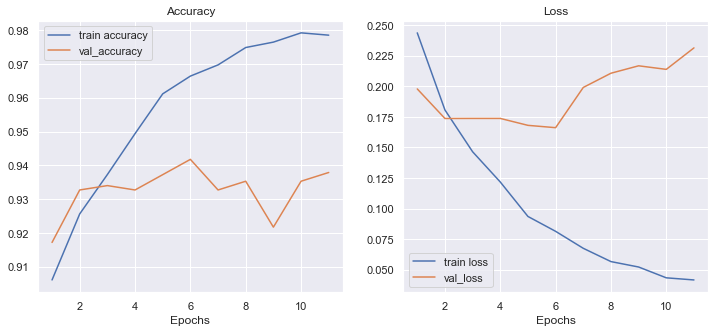

In [34]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, len(history.history['val_accuracy'])+1), 
         history.history['accuracy'], 
         label='train accuracy')
plt.plot(range(1, len(history.history['val_accuracy'])+1), 
         history.history['val_accuracy'], 
         label='val_accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epochs')

plt.subplot(1,2,2)
plt.plot(range(1, len(history.history['val_accuracy'])+1), 
         history.history['loss'], 
         label='train loss')
plt.plot(range(1, len(history.history['val_accuracy'])+1), 
         history.history['val_loss'], 
         label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.title('Loss')
plt.show()

# 4.9 Evaluating on Test Set

In [35]:
model.evaluate(X_test_pad, y_test)

81/81 [==============================] - 1s 8ms/step - loss: 0.1494 - accuracy: 0.9398


[0.14937397837638855, 0.9398291707038879]

In [36]:
y_pred = np.where(model.predict(X_test_pad) > .5, 1,0).reshape(1,-1)[0]

In [37]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1707
           1       0.94      0.88      0.91       869

    accuracy                           0.94      2576
   macro avg       0.94      0.93      0.93      2576
weighted avg       0.94      0.94      0.94      2576



In [39]:
cm = confusion_matrix(y_test, y_pred, labels=[0,1])

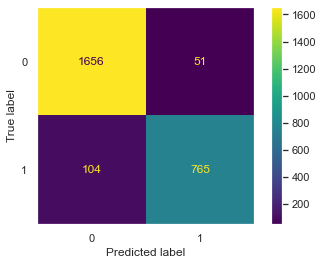

In [40]:
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.grid(None)
plt.show()

I noticed that approximately 4000 words from our tweets were missing from the GloVe embeddings which amounted to approximately 31% of the GloVe embedding vocabulary. A closer inspection of the words missing from the model revealed that these words were most likely hashtags. To overcome this issue, I went back to the preprocessing stage and removed hashtags and their contents. This resulted in  having 3613 words from our tweets missing from the GloVe embeddings. Unfortunately, when running the model again, our validation accuracy actually dropped to around 94% from the previous 98% accuracy.